# Getting started with LLMs

# Setup

Most of the time, you will interact with LLMs via an API.
OpenAI has an API standard that's been adopted by most other LLM providers.
Today, we'll be using `litellm`, a package that wraps multiple LLM providers with a common interface.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
from ctme.utils import get_root_dotenv
import os
from rich import print

In [3]:
env_path = get_root_dotenv(load=True)

expected_variables = [
    "GEMINI_API_KEY",
    "OPENROUTER_API_KEY"
]

assert any([os.getenv(e) for e in expected_variables]),  f"Expect at one of {expected_variables} to be populated"

In [4]:
# ...existing code...
env_path = get_root_dotenv(load=True)

expected_variables = [
    "GEMINI_API_KEY",
    "OPENROUTER_API_KEY"
]

missing = [e for e in expected_variables if not os.getenv(e)]
if len(missing) == len(expected_variables):
    raise EnvironmentError(f"Missing required environment variable(s): {missing}. At least one of {expected_variables} must be set.")
# ...existing code...

# The basics

Let's start by using the LLM `gemini-2.0-flash`'s free tier to learn about how to query LLMs.

In the cell below 👇, we import `completion` from `litellm`.
This is the core function we'll be using to chat with models in this section.

## Making requests

This model happens to be trained for chat.
Chat expects a `list` of messages.
Each message is a dictionary with a `role` field specifying the type of message, and a `content` field specifying the content of the message.
Three `role` values are supported:

- `system`, for giving general instructions to the LLM for how to behave
- `user`, for a user message, and
- `assistant`, for the LLM's response.

Let's give the LLM a simple prompt and see what it returns.

In [5]:
from litellm import completion, acompletion

In [6]:
GEMINI_MODEL = 'gemini/gemini-2.0-flash'

In [7]:
messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "Reverse the following string: 'abcde'. Let's think step by step:"},
]
response = completion(model=GEMINI_MODEL, messages=messages)
print(response)

ModelResponse(
    id='chatcmpl-7f4f6b99-7723-4f37-b799-fcc861c29693',
    created=1748019800,
    model='gemini-2.0-flash',
    object='chat.completion',
    system_fingerprint=None,
    choices=[
        Choices(
            finish_reason='stop',
            index=0,
            message=Message(
                content='Okay, let\'s reverse the string \'abcde\' step by step.\n\n1.  **Identify the string:** We
have the string "abcde".\n2.  **Determine the length:** The string has 5 characters.\n3.  **Iterate and swap (or 
build a new string in reverse):** There are a couple of ways to do this.  We could think about swapping characters 
from the outside in (a with e, then b with d, and c stays in the middle). Alternatively, we can construct a new 
string by taking the last character first, then the second to last, and so on. Let\'s do it that way.\n\n    *   
The last character \'e\' goes first.\n    *   Then the second to last character \'d\'.\n    *   Then \'c\'.\n    * 
Then \'b\'.\n    *   Then \'a\'.\n\n4.  **Combine the characters:**  Combining these in the reversed order gives us
"edcba".\n\nSo, the reversed string is \'edcba\'.\n',
                role='assistant',
                tool_calls=None,
                function_call=None,
                provider_specific_fields=None
            )
        )
    ],
    usage=Usage(
        completion_tokens=223,
        prompt_tokens=23,
        total_tokens=246,
        completion_tokens_details=None,
        prompt_tokens_details=PromptTokensDetailsWrapper(
            audio_tokens=None,
            cached_tokens=None,
            text_tokens=23,
            image_tokens=None
        )
    ),
    vertex_ai_grounding_metadata=[],
    vertex_ai_safety_results=[],
    vertex_ai_citation_metadata=[]
)

The response actually has a lot of useful information.
It has the model, a timestamp, other identifiers, and model-specific metadata like safety ratings in several different capacities.
But the real content is in the `choices` field.
Currently, the `choices` field only has one element containing the message returned by the LLM.
Let's access the LLM's response:

In [8]:
print(response.choices[0].message.content)

Okay, let's reverse the string 'abcde' step by step.

1.  **Identify the string:** We have the string "abcde".
2.  **Determine the length:** The string has 5 characters.
3.  **Iterate and swap (or build a new string in reverse):** There are a couple of ways to do this.  We could think
about swapping characters from the outside in (a with e, then b with d, and c stays in the middle). Alternatively, 
we can construct a new string by taking the last character first, then the second to last, and so on. Let's do it 
that way.

    *   The last character 'e' goes first.
    *   Then the second to last character 'd'.
    *   Then 'c'.
    *   Then 'b'.
    *   Then 'a'.

4.  **Combine the characters:**  Combining these in the reversed order gives us "edcba".

So, the reversed string is 'edcba'.

## Extending the chat history

In a chat setting, we also want to persist the response so we can continue the chat.
we can add it to the `messages` so we can ask a new question in the same dialog, assuming we want to create a message history.

In [9]:
assistant_message = response.choices[0].message.model_dump() # convert the last assistant message to a dictionary
messages.append(assistant_message) # append to the messages
print(assistant_message)

{
    'content': 'Okay, let\'s reverse the string \'abcde\' step by step.\n\n1.  **Identify the string:** We have the
string "abcde".\n2.  **Determine the length:** The string has 5 characters.\n3.  **Iterate and swap (or build a new
string in reverse):** There are a couple of ways to do this.  We could think about swapping characters from the 
outside in (a with e, then b with d, and c stays in the middle). Alternatively, we can construct a new string by 
taking the last character first, then the second to last, and so on. Let\'s do it that way.\n\n    *   The last 
character \'e\' goes first.\n    *   Then the second to last character \'d\'.\n    *   Then \'c\'.\n    *   Then 
\'b\'.\n    *   Then \'a\'.\n\n4.  **Combine the characters:**  Combining these in the reversed order gives us 
"edcba".\n\nSo, the reversed string is \'edcba\'.\n',
    'role': 'assistant',
    'tool_calls': None,
    'function_call': None
}

Since the whole history of messages is in-context and passed to the LLM, it can perform logical extensions of the original task as seen here:

In [10]:
new_message = {'role': 'user', 'content': "Now reverse it back to the same order."}
messages.append(new_message)

response = completion(model=GEMINI_MODEL, messages=messages)
print(response.choices[0].message.content)

Okay, let's reverse "edcba" back to its original order. We'll follow the same process:

1. **Identify the string:** We have the string "edcba".
2. **Determine the length:** The string has 5 characters.
3. **Iterate and swap (or build a new string in reverse):** Again, we'll construct a new string in reverse order.

    * The last character 'a' goes first.
    * Then the second to last character 'b'.
    * Then 'c'.
    * Then 'd'.
    * Then 'e'.

4. **Combine the characters:** Combining these gives us "abcde".

So, the reversed string is 'abcde'.

## Streaming responses

Another popular feature is streaming.
Since we're generating 1 token at a time, the API can also return text as it's generated.
This can be extra useful when you have long responses, and is nice in a user interface.

In [11]:
# streaming
response = completion(model=GEMINI_MODEL, messages=messages, stream=True)
for chunk in response:
    print(chunk.choices[0].delta.content, end='')

Okay

, let

's reverse "edcba" back to its original order, again step by step

:

1. **Identify the string:** We now have the string "edcba".

2. **Determine the length:** The string has 5 characters.
3. **Iterate and swap (or build a new string in reverse):

**  Let's use the same approach as before, building a new string by taking the characters in reverse order.

    * The last character 'a

' goes first.
    * Then the second to last character 'b'.
    * Then 'c'.
    * Then 'd'.
    * Then 'e'.

4. **Combine the characters:** Combining these in

the reversed order of the current string gives us "abcde".

So, the reversed string is 'abcde'.

None

## Async responses

When we make API calls to these models, the time it takes to make a request is relatively short but the inference time can be long.
Calling these APIs asynchronously lets us do other things while we're waiting for a response.
Without async, we are waiting for the first API call to be complete to begin making the second call.
Using async, we can make all the calls and `await` responses as they come in.

Here's an example of an async request 👇

In [12]:
# async
response = await acompletion(model=GEMINI_MODEL, messages=messages)
print(response.choices[0].message.content)

Okay, let's reverse the string "edcba" back to its original order. We'll follow a similar process:

1. **Identify the string:** We have the string "edcba".
2. **Determine the length:** The string has 5 characters.
3. **Iterate and swap (or build a new string in reverse):** Again, let's construct a new string in reverse order 
from the current string.

    * The last character 'a' goes first.
    * Then the second to last character 'b'.
    * Then 'c'.
    * Then 'd'.
    * Then 'e'.

4. **Combine the characters:** Combining these in the reversed order of the current string gives us "abcde".

Therefore, reversing "edcba" gives us back "abcde".

Now, let's demonstrate that we can make multiple simultaneous requests with async than we can with blocking requests.

In [13]:
import time
# With blocking requests
start = time.time()
for i in range(5):
    print(f"Making request {i}")
    response = completion(model=GEMINI_MODEL, messages=messages)
total_seconds = time.time() - start
print(f'Total time: {total_seconds} seconds')

Making request 0

Making request 1

Making request 2

Making request 3

Making request 4

Total time: 8.750880002975464 seconds

In [14]:
import asyncio
async def _acomplete(model, messages, i):
    print(f"Making request {i}")
    response = await acompletion(model=model, messages=messages)
    return response.choices[0].message.content

start = time.time()
tasks = [_acomplete(GEMINI_MODEL, messages, i) for i in range(5)]
responses = await asyncio.gather(*tasks)
total_seconds = time.time() - start
print(f'Total time: {total_seconds} seconds')

Making request 0

Making request 1

Making request 2

Making request 3

Making request 4

Total time: 1.6470861434936523 seconds

##  Exercise 1: Simple chatbot

Plese refer to the `01_our_first_chatbot` directory in the root of the repository.
In this exercise, you will complete the `chat` function in `chat.py` using the tools you learned in this notebook so far.
Documentation on `gradio.ChatInterface` can be found [here](https://www.gradio.app/guides/creating-a-chatbot-fast).
Follow this guide to make a chatbot.

**Bonus**: figure out how to add a system prompt and stream resopnses.

# Generation hyperparameters

Each model has different supported hyperparameters.
Let's evaluate the hyperparameters here and get a good feeling for what they do.
`litellm` has a handy function to tell us what parameters the model expects.

In [15]:
from litellm import get_supported_openai_params
get_supported_openai_params(model=GEMINI_MODEL)

['temperature',
 'top_p',
 'max_tokens',
 'max_completion_tokens',
 'stream',
 'tools',
 'tool_choice',
 'functions',
 'response_format',
 'n',
 'stop',
 'logprobs',
 'frequency_penalty',
 'modalities']

## `temperature`

Let's recall that temperature alters the softmax function to skew the probability distribution of tokens during decoding.
To illustrate, let's look at the interactive plot below 👇.
We have a small probability distribution representing the top probabilities at a single decoding step.
There are 5 tokens, `A`, `B`, `C`, `D`, and `E`, where `A` is the most probable with a score of 0.5 and `D` and `E` are at the bottom with a score of 0.05.

## `softmax_with_temperature` visualization

Please fill in the `softmax_with_temperature` function.
Since we're not doing any backpropagation, let's use `numpy`.

The softmax with temperature function is as follows:

$\text{softmax}(p, T) = \frac{\exp\left(\frac{\log(p_i)}{T}\right)}{\sum_{j}
\exp\left(\frac{\log(p_j)}{T}\right)}$

Where:
- $p_i$  represents the original probability values.
- $T$  is the temperature parameter.
- $\exp$  is the exponential function.

Run the cell and play with the widget below.
If temperature is smaller, how do you think that will affect text generation?
What about when temperature is large?
Most LLM providers cap temperature at 2.0.
Why might you do this?

In [16]:
from ctme.basics import temperature_plot_distribution
import numpy as np
from ipywidgets import interact, fixed, FloatSlider

probs = fixed(np.array([0.5, 0.3, 0.1, 0.05, 0.05]))
temperature=FloatSlider(value=0.9, min=.1, max=3)


interact(temperature_plot_distribution, probs=probs, temperature=temperature)

interactive(children=(FloatSlider(value=0.9, description='temperature', max=3.0, min=0.1), Output()), _dom_cla…

<function ctme.basics.plot_temperature.temperature_plot_distribution(probs: numpy.ndarray, temperature: float)>

Now that we've got a good feeling for what `temperature` does to the probability distribution, let's examine some of the outputs.
In addition to qualitatively observing the outputs, we will calculate the similarity between each pair of generations using `fuzzywuzzy`, a library that calculates similarity using levenshtein distance.
Roughly, it's based on the number of characters we'd have to change to turn string 1 into string 2.
100 is exact match, and 0 is no match.


In [17]:
from thefuzz import fuzz

In [18]:
# perfect match, 50% matc, 0 match
fuzz.ratio('a', 'a'), fuzz.ratio('ab', 'bb'), fuzz.ratio('a', 'b')

(100, 50, 0)

In [19]:
messages = [
    {'role': 'user', 'content': 'write a limerick about python'}
]

In [20]:
from itertools import combinations
from thefuzz import fuzz

In [21]:
contents = []
for choice in completion(model=GEMINI_MODEL, messages=messages, temperature=0, n=5).choices:
    content = choice.message.content
    contents.append(content)
combos = combinations(contents, 2)
ratios = [fuzz.ratio(c1, c2) for c1, c2 in combos]
print(f"Average text similarity (fuzz.ratio): {np.mean(ratios)}")
for c in contents:
    print(c)
    print('='*40)

Average text similarity (fuzz.ratio): 100.0

A coder named Guido, so grand,
Made Python, a language at hand.
With syntax so neat,
It can't be beat,
A joy for the whole coding land.

========================================

A coder named Guido, so grand,
Made Python, a language at hand.
With syntax so neat,
It can't be beat,
A joy for the whole coding land.

========================================

A coder named Guido, so grand,
Made Python, a language at hand.
With syntax so neat,
It can't be beat,
A joy for the whole coding land.

========================================

A coder named Guido, so grand,
Made Python, a language at hand.
With syntax so neat,
It can't be beat,
A joy for the whole coding land.

========================================

A coder named Guido, so grand,
Made Python, a language at hand.
With syntax so neat,
It can't be beat,
A joy for the whole coding land.

========================================

In [22]:
contents = []
for choice in completion(model=GEMINI_MODEL, messages=messages, temperature=1.9, n=5).choices:
    content = choice.message.content
    contents.append(content)
combos = combinations(contents, 2)
ratios = [fuzz.ratio(c1, c2) for c1, c2 in combos]
print(f"Average text similarity (fuzz.ratio): {np.mean(ratios)}")
for c in contents:
    print(c)
    print('='*40)

Average text similarity (fuzz.ratio): 46.9

There once was a coder named Lou,
Whose scripts were a beautiful hue.
With Python he'd weave,
Code that would cleave,
Tasks finished before his code brewed!

========================================

A coder named Stan, quite astute,
Used Python for all he would do.
With elegant grace,
He'd fill up his space,
And build programs that ran straight through.

========================================

A coder named Guido, quite sly,
Made Python, reaching for the sky.
With syntax so neat,
A coder's sweet treat,
It helps dreams and ideas to fly!

========================================

There once was a snake named Python,
Whose code was quite easy to write on.
With a loop and a function,
And no punctuation,
It could charm with its slithery bright on.

========================================

Young Guido, with foresight so keen,
Made Python, a coding machine.
With syntax so neat,
It's a joy to repeat,
And write scripts that are awfully mean.

========================================

## `top_p` (nucleus sampling)

Let's re-visit top-p sampling.
We definie the cumulative sum of the probabilitity distribution we want to allow for decoding.
Let's formally define it:


$\text{Top-p sampling:} \quad P(S) = \{x_i \mid \sum_{x_j \in S} P(x_j) \geq p \}$

Where:

- $P(x_i)$  is the probability of token  x_i .
- $S$  is the set of selected tokens.
- $p$  is the cumulative probability threshold (top-p value).

In short, we take the set of all tokens such that the sum of the token probabilities is greater than or equal to the parameter $p$.
Let's illustrate this in anoher widget.


In [23]:
from ctme.basics import top_p_plot_distribution

# Define a small probability distribution (can simulate a language model's logits)
probs = fixed(np.array([0.4, 0.2, 0.15, 0.1, 0.08, 0.05, 0.02]))

interact(top_p_plot_distribution, probs=probs, p=(0.01, 1.0, 0.05))

interactive(children=(FloatSlider(value=0.46, description='p', max=1.0, min=0.01, step=0.05), Output()), _dom_…

<function ctme.basics.plot_top_p.top_p_plot_distribution(probs, p)>

## Relationship between `top_p` and sequence similarity

Just like `temperature`, `top_p` is another lever to control how text is generated.
Let's visualize how modulating `top_p` affects average similarity.

In [24]:
import pandas as pd
import seaborn as sns

<Axes: xlabel='top_p', ylabel='ratio'>

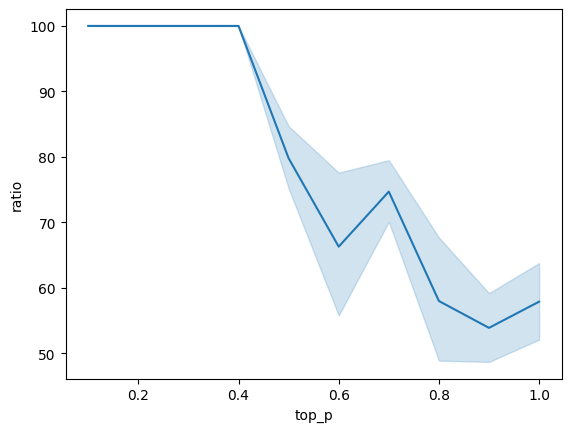

In [26]:
results = []
# Create a range of p values
ps = np.arange(0.1,1.1,.1)
# For each p...
results = []
for p in ps:
    # Generate 5 choices at that top p
    contents = []
    for choice in completion(model=GEMINI_MODEL, messages=messages, top_p=p, n=5).choices:
        content = choice.message.content
        contents.append(content)
    # Make combinations of each pair of contents
    combos = combinations(contents, 2)
    # Calculate the ratio of each of those combinations
    ratios = [fuzz.ratio(c1, c2) for c1, c2 in combos]
    for r in ratios:
        results.append(dict(top_p=p, ratio=r))
results = pd.DataFrame(results)

sns.lineplot(x='top_p', y='ratio', data=results)

# Structured outputs

Many times, we want to use LLMs as middleware in other systems.
That means they may have to do things like extract structured data, populate parameters to API calls, etc.
This is really hard to do with plain text LLM responses - you have to do lots of "begging" to get the LLM to output a consistent structure.

For this next section, we're going to switch to OpenAI's API since it's much better than gemini at producing structured outputs.
We will be using `gpt-4o-mini`.

The most convenient way to declare what you want to return is with `pydantic` models.
These are really useful because you can define exactly the values, formats, and types you expect back.
As you can see in the `EventDetails` class below, we've specified all the information we want to know about an event.
We can even describe complex objects, like lists or dicts of other objects.

In [27]:
from pydantic import BaseModel, Field
from typing import List, Optional
from datetime import date
import json

In [28]:
class EventDetails(BaseModel):
    attendees: List[str] = Field(..., description="List of attendees")
    date: Optional[str] = Field(..., description="Date of the event, in the YYYY-MM-DD format")
    eventName: str = Field(..., description="Name of the event")

In [29]:
text = "Jan and Peter are going to have dinner"
resp = completion(
    model=GEMINI_MODEL,
    messages=[
        {'role': 'system', 'content': f"Today's date is {date.today()}. Do not include any information not in the message."},
        {"role": "user", "content": text}
        ],
    response_format=EventDetails)

In [ ]:
# Print the raw content from the response
print("Response text:\n", c:=resp.choices[0].message.content)
# Print the JSON content
print("Loaded JSON:", j:=json.loads(c))
# Print the Pydantic object
print("Pydantic object:", o:=EventDetails.model_validate_json(c))

Response text:
 {
  "attendees": ["Jan", "Peter"],
  "date": "2025-05-23",
  "eventName": "Dinner"
}

Loaded JSON:
{'attendees': ['Jan', 'Peter'], 'date': '2025-05-23', 'eventName': 'Dinner'}

Pydantic object:
EventDetails(attendees=['Jan', 'Peter'], date='2025-05-23', eventName='Dinner')

# Function calling

In [39]:
import litellm

In [40]:
print(f"{GEMINI_MODEL} supports function calling: ", litellm.supports_function_calling(model=GEMINI_MODEL))


gemini/gemini-2.0-flash supports function calling:  True

In [41]:
from typing import Union
from datetime import timedelta
import yfinance as yf
from IPython.display import display, Markdown

In [43]:
def get_stock_data(
        symbols:Union[str, List[str]],
        start_date:Optional[str]=str(date.today() - timedelta(days=7)),
        end_date:Optional[str] = str(date.today())
):
    """
    Gets stock data using the yfinance package.

    Args:
        symbols (Union[str, List[str]]): Ticker symbol or list of ticker symbols
        start_date (str): Earliest date to capture. Default is 7 days ago from today.
        end_date (str): Latest date to capture. Default is today.
    """
    result:pd.DataFrame = yf.download(symbols, start=start_date, end=end_date)
    return result.to_markdown()

In [44]:
display(Markdown(get_stock_data('MSFT')))

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


| Date                |   ('Close', 'MSFT') |   ('High', 'MSFT') |   ('Low', 'MSFT') |   ('Open', 'MSFT') |   ('Volume', 'MSFT') |
|:--------------------|--------------------:|-------------------:|------------------:|-------------------:|---------------------:|
| 2025-05-16 00:00:00 |              454.27 |             454.36 |            448.73 |             452.05 |          2.38498e+07 |
| 2025-05-19 00:00:00 |              458.87 |             459.59 |            450.8  |             450.88 |          2.13365e+07 |
| 2025-05-20 00:00:00 |              458.17 |             458.34 |            454.32 |             455.59 |          1.54418e+07 |
| 2025-05-21 00:00:00 |              452.57 |             457.78 |            451.81 |             454.57 |          1.92169e+07 |
| 2025-05-22 00:00:00 |              454.86 |             460.25 |            453.9  |             454.95 |          1.79954e+07 |

In [45]:
fn_json = litellm.utils.function_to_dict(get_stock_data)
functions = [fn_json]
print(functions)

[
    {
        'name': 'get_stock_data',
        'description': 'Gets stock data using the yfinance package.',
        'parameters': {
            'type': 'object',
            'properties': {
                'symbols': {'type': 'string'},
                'start_date': {'type': 'string'},
                'end_date': {'type': 'string'}
            },
            'required': ['symbols']
        }
    }
]

In [46]:
messages = [{"role": "user", "content": f"What's the most recent week's high and low for MSFT? Today's date is {date.today()}."}]
resp = completion(
    model=GEMINI_MODEL,
    messages=messages,
    tools=functions,
    tool_choice='auto'
)

In [47]:
message = resp.choices[0].message
print(message)

Message(
    content=None,
    role='assistant',
    tool_calls=[
        ChatCompletionMessageToolCall(
            index=0,
            function=Function(
                arguments='{"start_date": "2025-05-16", "end_date": "2025-05-23", "symbols": "MSFT"}',
                name='get_stock_data'
            ),
            id='call_240f8004-e41c-45f8-afa1-c989f9c884bf',
            type='function'
        )
    ],
    function_call=None,
    provider_specific_fields=None
)

In [48]:
tool_call = message.tool_calls[0]
print(tool_call)

ChatCompletionMessageToolCall(
    index=0,
    function=Function(
        arguments='{"start_date": "2025-05-16", "end_date": "2025-05-23", "symbols": "MSFT"}',
        name='get_stock_data'
    ),
    id='call_240f8004-e41c-45f8-afa1-c989f9c884bf',
    type='function'
)

In [ ]:
# Get the function name
func:str|None = tool_call.function.name
# Get the function arguments
args:str = json.loads(tool_call.function.arguments)
output_str:str = eval(f"{func}(**{args})")
display(Markdown(output_str))

[*********************100%***********************]  1 of 1 completed


| Date                |   ('Close', 'MSFT') |   ('High', 'MSFT') |   ('Low', 'MSFT') |   ('Open', 'MSFT') |   ('Volume', 'MSFT') |
|:--------------------|--------------------:|-------------------:|------------------:|-------------------:|---------------------:|
| 2025-05-16 00:00:00 |              454.27 |             454.36 |            448.73 |             452.05 |          2.38498e+07 |
| 2025-05-19 00:00:00 |              458.87 |             459.59 |            450.8  |             450.88 |          2.13365e+07 |
| 2025-05-20 00:00:00 |              458.17 |             458.34 |            454.32 |             455.59 |          1.54418e+07 |
| 2025-05-21 00:00:00 |              452.57 |             457.78 |            451.81 |             454.57 |          1.92169e+07 |
| 2025-05-22 00:00:00 |              454.86 |             460.25 |            453.9  |             454.95 |          1.79954e+07 |

In [51]:
messages.append(message.model_dump())
messages.append(
    {
        "tool_call_id": tool_call.id,
        "role": "tool",
        "name": func,
        "content": output_str,
    }
)

In [52]:
print(messages)

[
    {
        'role': 'user',
        'content': "What's the most recent week's high and low for MSFT? Today's date is 2025-05-23."
    },
    {
        'content': None,
        'role': 'assistant',
        'tool_calls': [
            {
                'index': 0,
                'function': {
                    'arguments': '{"start_date": "2025-05-16", "end_date": "2025-05-23", "symbols": "MSFT"}',
                    'name': 'get_stock_data'
                },
                'id': 'call_240f8004-e41c-45f8-afa1-c989f9c884bf',
                'type': 'function'
            }
        ],
        'function_call': None
    },
    {
        'tool_call_id': 'call_240f8004-e41c-45f8-afa1-c989f9c884bf',
        'role': 'tool',
        'name': 'get_stock_data',
        'content': "| Date                |   ('Close', 'MSFT') |   ('High', 'MSFT') |   ('Low', 'MSFT') |   
('Open', 'MSFT') |   ('Volume', 'MSFT') 
|\n|:--------------------|--------------------:|-------------------:|------------------:|-------------------:|-----
----------------:|\n| 2025-05-16 00:00:00 |              454.27 |             454.36 |            448.73 |         
452.05 |          2.38498e+07 |\n| 2025-05-19 00:00:00 |              458.87 |             459.59 |            
450.8  |             450.88 |          2.13365e+07 |\n| 2025-05-20 00:00:00 |              458.17 |             
458.34 |            454.32 |             455.59 |          1.54418e+07 |\n| 2025-05-21 00:00:00 |              
452.57 |             457.78 |            451.81 |             454.57 |          1.92169e+07 |\n| 2025-05-22 
00:00:00 |              454.86 |             460.25 |            453.9  |             454.95 |          1.79954e+07
|"
    }
]

In [53]:
resp = completion(
    model=GEMINI_MODEL,
    messages=messages
)

In [54]:
print(resp.choices[0].message.content)

The most recent week's (2025-05-16 to 2025-05-22) high for MSFT was 460.25 and the low was 448.73.

In [ ]:
# ...existing code...
env_path = get_root_dotenv(load=True)

expected_variables = [
    "GEMINI_API_KEY",
    "OPENROUTER_API_KEY"
]

missing = [e for e in expected_variables if not os.getenv(e)]
if len(missing) == len(expected_variables):
    raise EnvironmentError(f"Missing required environment variable(s): {missing}. At least one of {expected_variables} must be set.")
# ...existing code...